# Convolutional Neural Networks

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

In this lesson we will learn the basics of Convolutional Neural Networks (CNNs) applied to text for natural language processing (NLP) tasks. CNNs are traditionally used on images and there are plenty of [tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) that cover this. But we're going to focus on using CNN on text data which yields amazing results. 



# Overview

The diagram below from this [paper](https://arxiv.org/abs/1510.03820) shows how 1D convolution is applied to the words in a sentence. 

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/cnn_text.png" width=500>

* **Objective:**  Detect spatial substructure from input data.
* **Advantages:** 
  * Small number of weights (shared)
  * Parallelizable
  * Detects spatial substrcutures (feature extractors)
  * Interpretable via filters
  * Used for in images/text/time-series etc.
* **Disadvantages:**
  * Many hyperparameters (kernel size, strides, etc.)
  * Inputs have to be of same width (image dimensions, text length, etc.)
* **Miscellaneous:** 
  * Lot's of deep CNN architectures constantly updated for SOTA performance

# Filters

At the core of CNNs are filters (weights, kernels, etc.) which convolve (slide) across our input to extract relevant features. The filters are initialized randomly but learn to pick up meaningful features from the input that aid in optimizing for the objective. We're going to teach CNNs in an unorthodox method where we entirely focus on applying it to 2D text data. Each input is composed of words and we will be representing each word as one-hot encoded vector which gives us our 2D input. The intuition here is that each filter represents a feature and we will use this filter on other inputs to capture the same feature. This is known as parameter sharing.

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/conv.gif" width=400>

In [1]:
# Loading PyTorch library
!pip3 install torch

In [0]:
import torch
import torch.nn as nn

Our inputs are a batch of 2D text data. Let's make an input with 64 samples, where each sample has 8 words and each word is represented by a array of 10 values (one hot encoded with vocab size of 10). This gives our inputs the size (64, 8, 10). The [PyTorch CNN modules](https://pytorch.org/docs/stable/nn.html#convolution-functions) prefer inputs to have the channel dim (one hot vector dim in our case) to be in the second position, so our inputs are of shape (64, 10, 8).

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/cnn_text1.png" width=400>

In [3]:
# Assume all our inputs have the same # of words
batch_size = 64
sequence_size = 8 # words per input
one_hot_size = 10 # vocab size (num_input_channels)
x = torch.randn(batch_size, one_hot_size, sequence_size)
print("Size: {}".format(x.shape))

Size: torch.Size([64, 10, 8])


We want to convolve on this input using filters. For simplicity we will use just 5 filters that is of size (1, 2) and has the same depth as the number of channels (one_hot_size). This gives our filter a shape of (5, 2, 10) but recall that PyTorch CNN modules prefer to have the channel dim (one hot vector dim in our case) to be in the second position so the filter is of shape (5, 10, 2).

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/cnn_text2.png" width=400>

In [4]:
# Create filters for a conv layer
out_channels = 5 # of filters
kernel_size = 2 # filters size 2
conv1 = nn.Conv1d(in_channels=one_hot_size, out_channels=out_channels, kernel_size=kernel_size)
print("Size: {}".format(conv1.weight.shape))
print("Filter size: {}".format(conv1.kernel_size[0]))
print("Padding: {}".format(conv1.padding[0]))
print("Stride: {}".format(conv1.stride[0]))

Size: torch.Size([5, 10, 2])
Filter size: 2
Padding: 0
Stride: 1


When we apply this filter on our inputs, we receive an output of shape (64, 5, 7). We get 64 for the batch size, 5 for the channel dim because we used 5 filters and 7 for the conv outputs because:

$\frac{W - F + 2P}{S} + 1 = \frac{8 - 2 + 2(0)}{1} + 1 = 7$

where:
  * W: width of each input
  * F: filter size
  * P: padding
  * S: stride

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/cnn_text3.png" width=400>

In [5]:
# Convolve using filters
conv_output = conv1(x)
print("Size: {}".format(conv_output.shape))

Size: torch.Size([64, 5, 7])


# Pooling

The result of convolving filters on an input is a feature map. Due to the nature of convolution and overlaps, our feature map will have lots of redundant information. Pooling is a way to summarize a high-dimensional feature map into a lower dimensional one for simplified downstream computation. The pooling operation can be the max value, average, etc. in a certain receptive field.

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/pool.jpeg" width=450>

In [6]:
# Max pooling
kernel_size = 2
pool1 = nn.MaxPool1d(kernel_size=kernel_size, stride=2, padding=0)
pool_output = pool1(conv_output)
print("Size: {}".format(pool_output.shape))

Size: torch.Size([64, 5, 3])


$\frac{W-F}{S} + 1 = \frac{7-2}{2} + 1 =  \text{floor }(2.5) + 1 = 3$

# CNNs on text

We're going use convolutional neural networks on text data which typically involves convolving on the character level representation of the text to capture meaningful n-grams. 

You can easily use this set up for [time series](https://arxiv.org/abs/1807.10707) data or [combine it](https://arxiv.org/abs/1808.04928) with other networks. For text data, we will create filters of varying kernel sizes (1,2), (1,3), and (1,4) which act as feature selectors of varying n-gram sizes. The outputs are concated and fed into a fully-connected layer for class predictions. In our example, we will be applying 1D convolutions on letter in a word. In the [embeddings notebook](https://colab.research.google.com/github/GokuMohandas/practicalAI/blob/master/notebooks/12_Embeddings.ipynb), we will apply 1D convolutions on words in a sentence.

**Word embeddings**: capture the temporal correlations among
adjacent tokens so that similar words have similar representations. Ex. "New Jersey" is close to "NJ" is close to "Garden State", etc.

**Char embeddings**: create representations that map words at a character level. Ex. "toy" and "toys" will be close to each other.

# Set up

In [0]:
import os
from argparse import Namespace
import collections
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch

In [0]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
# Creating directories
def create_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [9]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True,
    data_file="names.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="names",
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    num_epochs=20,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=64,
    num_filters=100,
    dropout_p=0.1,
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Create save dir
create_dirs(args.save_dir)

# Expand filepaths
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: False


# Data

In [0]:
import re
import urllib

In [0]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/surnames.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [12]:
# Raw data
df = pd.read_csv(args.data_file, header=0)
df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [13]:
# Split by nationality
by_nationality = collections.defaultdict(list)
for _, row in df.iterrows():
    by_nationality[row.nationality].append(row.to_dict())
for nationality in by_nationality:
    print ("{0}: {1}".format(nationality, len(by_nationality[nationality])))

English: 2972
French: 229
Arabic: 1603
Russian: 2373
Japanese: 775
Chinese: 220
Italian: 600
Czech: 414
Irish: 183
German: 576
Greek: 156
Spanish: 258
Polish: 120
Dutch: 236
Vietnamese: 58
Korean: 77
Portuguese: 55
Scottish: 75


In [0]:
# Create split data
final_list = []
for _, item_list in sorted(by_nationality.items()):
    if args.shuffle:
        np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_size*n)
    n_val = int(args.val_size*n)
    n_test = int(args.test_size*n)

  # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  

    # Add to final list
    final_list.extend(item_list)

In [15]:
# df with split datasets
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

train    7680
test     1660
val      1640
Name: split, dtype: int64

In [18]:
# Preprocessing
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
split_df.surname = split_df.surname.apply(preprocess_text)
split_df.head()

,nationality,split,surname
0,Arabic,train,bishara
1,Arabic,train,nahas
2,Arabic,train,ghanem
3,Arabic,train,tannous
4,Arabic,train,mikhail


# Vocabulary

In [0]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):

        # Token to index
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}
        
        # Add unknown token
        self.add_unk = add_unk
        self.unk_token = unk_token
        if self.add_unk:
            self.unk_index = self.add_token(self.unk_token)

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx,
                'add_unk': self.add_unk, 'unk_token': self.unk_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        if self.add_unk:
            index = self.token_to_idx.get(token, self.unk_index)
        else:
            index =  self.token_to_idx[token]
        return index

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

In [20]:
# Vocabulary instance
nationality_vocab = Vocabulary(add_unk=False)
for index, row in df.iterrows():
    nationality_vocab.add_token(row.nationality)
print (nationality_vocab) # __str__
index = nationality_vocab.lookup_token("English")
print (index)
print (nationality_vocab.lookup_index(index))

<Vocabulary(size=18)>
0
English


# Vectorizer

In [0]:
class SurnameVectorizer(object):
    def __init__(self, surname_vocab, nationality_vocab):
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        one_hot_matrix_size = (len(surname), len(self.surname_vocab))
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)
                               
        for position_index, character in enumerate(surname):
            character_index = self.surname_vocab.lookup_token(character)
            one_hot_matrix[position_index][character_index] = 1
        
        return one_hot_matrix
    
    def unvectorize(self, one_hot_matrix):
        len_name = len(one_hot_matrix)
        indices = np.zeros(len_name)
        for i in range(len_name):
            indices[i] = np.where(one_hot_matrix[i]==1)[0][0]
        surname = [self.surname_vocab.lookup_index(index) for index in indices]
        return surname

    @classmethod
    def from_dataframe(cls, df):
        surname_vocab = Vocabulary(add_unk=True)
        nationality_vocab = Vocabulary(add_unk=False)

        # Create vocabularies
        for index, row in df.iterrows():
            for letter in row.surname: # char-level tokenization
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)
        return cls(surname_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab, nationality_vocab)

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}

In [22]:
# Vectorizer instance
vectorizer = SurnameVectorizer.from_dataframe(split_df)
print (vectorizer.surname_vocab)
print (vectorizer.nationality_vocab)
vectorized_surname = vectorizer.vectorize(preprocess_text("goku"))
print (np.shape(vectorized_surname))
print (vectorized_surname)
print (vectorizer.unvectorize(vectorized_surname))

<Vocabulary(size=28)>
<Vocabulary(size=18)>
(4, 28)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
['g', 'o', 'k', 'u']


**Note**: Unlike the bagged ont-hot encoding method in the MLP notebook, we are able to preserve the semantic structure of the surnames. We are able to use one-hot encoding here because we are using characters but when we process text with large vocabularies, this method simply can't scale. We'll explore embedding based methods in subsequent notebooks. 

# Dataset

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class SurnameDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights (for imbalances)
        class_counts = df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, df):
        train_df = df[df.split=='train']
        return cls(df, SurnameVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, df, vectorizer_filepath):
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        surname_vector = self.vectorizer.vectorize(row.surname)
        nationality_index = self.vectorizer.nationality_vocab.lookup_token(row.nationality)
        return {'surname': surname_vector, 'nationality': nationality_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, collate_fn, shuffle=True, 
                         drop_last=True, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size,
                                collate_fn=collate_fn, shuffle=shuffle, 
                                drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [27]:
# Dataset instance
dataset = SurnameDataset.load_dataset_and_make_vectorizer(split_df)
print (dataset) # __str__
print (np.shape(dataset[5]['surname'])) # __getitem__
print (dataset.class_weights)

<Dataset(split=train, size=7680)
(6, 28)
tensor([0.0006, 0.0045, 0.0024, 0.0042, 0.0003, 0.0044, 0.0017, 0.0064, 0.0055,
        0.0017, 0.0013, 0.0130, 0.0083, 0.0182, 0.0004, 0.0133, 0.0039, 0.0172])


# Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class SurnameModel(nn.Module):
    def __init__(self, num_input_channels, num_output_channels, num_classes, dropout_p):
        super(SurnameModel, self).__init__()
        
        # Conv weights
        self.conv = nn.ModuleList([nn.Conv1d(num_input_channels, num_output_channels, 
                                             kernel_size=f) for f in [2,3,4]])
        self.dropout = nn.Dropout(dropout_p)
       
        # FC weights
        self.fc1 = nn.Linear(num_output_channels*3, num_classes)

    def forward(self, x, channel_first=False, apply_softmax=False):
        
        # Rearrange input so num_input_channels is in dim 1 (N, C, L)
        if not channel_first:
            x = x.transpose(1, 2)
            
        # Conv outputs
        z = [conv(x) for conv in self.conv]
        z = [F.max_pool1d(zz, zz.size(2)).squeeze(2) for zz in z]
        z = [F.relu(zz) for zz in z]
        
        # Concat conv outputs
        z = torch.cat(z, 1)
        z = self.dropout(z)

        # FC layer
        y_pred = self.fc1(z)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

# Training

**Padding:** the inputs in a particular batch must all have the same shape. Our vectorizer converts the tokens into a vectorizer form but in a particular batch, we can have inputs of various sizes. The solution is to determine the longest input in a particular batch and pad all the other inputs to match that length. Usually, the smaller inputs in the batch are padded with zero vectors. 

We do this using the pad_seq function in the Trainer class which is invoked by the collate_fn which is passed to generate_batches function in the Dataset class. Essentially, the batch generater generates samples into a batch and we use the collate_fn to determine the largest input and pad all the other inputs in the batch to get a uniform input shape.

In [0]:
import torch.optim as optim

In [0]:
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'done_training': False,
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # Verbose
        print ("[EPOCH]: {0} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # Save one model at least
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # Save model if performance improved
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # Loss decreased
            else:
                # Save the best model
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # Reset early stopping step
                self.train_state['early_stopping_step'] = 0

            # Stop early ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
    
    def pad_seq(self, seq, length):
        vector = np.zeros((length, len(self.dataset.vectorizer.surname_vocab)),
                          dtype=np.int64)
        for i in range(len(seq)):
            vector[i] = seq[i]
        return vector
    
    def collate_fn(self, batch):
        
        # Make a deep copy
        batch_copy = copy.deepcopy(batch)
        processed_batch = {"surname": [], "nationality": []}
        
        # Get max sequence length
        max_seq_len = max([len(sample["surname"]) for sample in batch_copy])
        
        # Pad
        for i, sample in enumerate(batch_copy):
            seq = sample["surname"]
            nationality = sample["nationality"]
            padded_seq = self.pad_seq(seq, max_seq_len)
            processed_batch["surname"].append(padded_seq)
            processed_batch["nationality"].append(nationality)
            
        # Convert to appropriate tensor types
        processed_batch["surname"] = torch.FloatTensor(
            processed_batch["surname"]) # need float for conv operations
        processed_batch["nationality"] = torch.LongTensor(
            processed_batch["nationality"])
        
        return processed_batch    
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # initialize batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn,
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # zero the gradients
                self.optimizer.zero_grad()

                # compute the output
                y_pred = self.model(batch_dict['surname'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['nationality'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()
                
                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # initialize batch generator, set loss and acc to 0; set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  self.model(batch_dict['surname'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['nationality'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # initialize batch generator, set loss and acc to 0; set eval mode on
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, collate_fn=self.collate_fn,
            shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['surname'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()
    
    def save_train_state(self):
        self.train_state["done_training"] = True
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

In [33]:
# Initialization
dataset = SurnameDataset.load_dataset_and_make_vectorizer(split_df)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = SurnameModel(num_input_channels=len(vectorizer.surname_vocab),
                     num_output_channels=args.num_filters,
                     num_classes=len(vectorizer.nationality_vocab),
                     dropout_p=args.dropout_p)
print (model.named_modules)

<bound method Module.named_modules of SurnameModel(
  (conv): ModuleList(
    (0): Conv1d(28, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(28, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(28, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=18, bias=True)
)>


In [34]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 2.82 | [TRAIN ACC]: 20.2% | [VAL LOSS]: 2.71 | [VAL ACC]: 37.1%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 2.54 | [TRAIN ACC]: 43.9% | [VAL LOSS]: 2.40 | [VAL ACC]: 49.8%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 2.18 | [TRAIN ACC]: 48.7% | [VAL LOSS]: 2.12 | [VAL ACC]: 48.2%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 1.88 | [TRAIN ACC]: 51.1% | [VAL LOSS]: 1.90 | [VAL ACC]: 50.6%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 1.67 | [TRAIN ACC]: 54.8% | [VAL LOSS]: 1.74 | [VAL ACC]: 50.6%
[EPOCH]: 05 | [LR]: 0.001 | [TRAIN LOSS]: 1.52 | [TRAIN ACC]: 57.4% | [VAL LOSS]: 1.65 | [VAL ACC]: 55.8%
[EPOCH]: 06 | [LR]: 0.001 | [TRAIN LOSS]: 1.37 | [TRAIN ACC]: 60.0% | [VAL LOSS]: 1.60 | [VAL ACC]: 60.4%
[EPOCH]: 07 | [LR]: 0.001 | [TRAIN LOSS]: 1.28 | [TRAIN ACC]: 62.2% | [VAL LOSS]: 1.53 | [VAL ACC]: 59.8%
[EPOCH]: 08 | [LR]: 0.001 | [TRAIN LOSS]: 1.20 | [TRAIN ACC]: 63.0% | [VAL LOSS]: 1.49 | [VAL ACC]: 58.5%
[EPOCH]: 09 | [LR]: 0.001 | [TRAIN LOSS]: 1.12

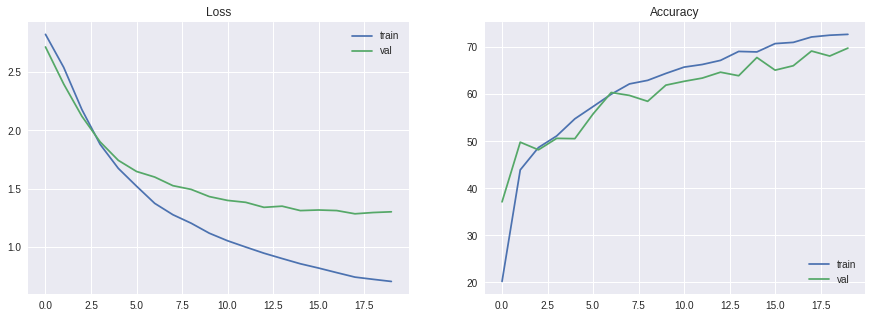

In [35]:
# Plot performance
trainer.plot_performance()

In [36]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 1.30
Test Accuracy: 68.2%


In [0]:
# Save all results
trainer.save_train_state()

# Inference

In [0]:
class Inference(object):
    def __init__(self, model, vectorizer, device="cpu"):
        self.model = model.to(device)
        self.vectorizer = vectorizer
        self.device = device
  
    def predict_nationality(self, dataset):
        # Batch generator
        batch_generator = dataset.generate_batches(
            batch_size=len(dataset), shuffle=False, device=self.device)
        self.model.eval()
        
        # Predict
        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['surname'], apply_softmax=True)

            # Top k nationalities
            y_prob, indices = torch.topk(y_pred, k=len(self.vectorizer.nationality_vocab))
            probabilities = y_prob.detach().to('cpu').numpy()[0]
            indices = indices.detach().to('cpu').numpy()[0]

            results = []
            for probability, index in zip(probabilities, indices):
                nationality = self.vectorizer.nationality_vocab.lookup_index(index)
                results.append({'nationality': nationality, 'probability': probability})

        return results

In [0]:
# Load vectorizer
with open(args.vectorizer_file) as fp:
    vectorizer = SurnameVectorizer.from_serializable(json.load(fp))

In [43]:
# Load the model
model = SurnameModel(num_input_channels=len(vectorizer.surname_vocab),
                     num_output_channels=args.num_filters,
                     num_classes=len(vectorizer.nationality_vocab),
                     dropout_p=args.dropout_p)
model.load_state_dict(torch.load(args.model_state_file))
print (model.named_modules)

<bound method Module.named_modules of SurnameModel(
  (conv): ModuleList(
    (0): Conv1d(28, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(28, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(28, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=18, bias=True)
)>


In [0]:
# Initialize
inference = Inference(model=model, vectorizer=vectorizer, device=args.device)

In [0]:
class InferenceDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer
        self.target_size = len(self.df)

    def __str__(self):
        return "<Dataset(size={1})>".format(self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.df.iloc[index]
        surname_vector = self.vectorizer.vectorize(row.surname)
        return {'surname': surname_vector}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, shuffle=True, drop_last=False, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [46]:
# Inference
surname = input("Enter a surname to classify: ")
infer_df = pd.DataFrame([surname], columns=['surname'])
infer_df.surname = infer_df.surname.apply(preprocess_text)
infer_dataset = InferenceDataset(infer_df, vectorizer)
results = inference.predict_nationality(dataset=infer_dataset)
results

Enter a surname to classify: Goku


[{'nationality': 'Japanese', 'probability': 0.91458},
 {'nationality': 'Russian', 'probability': 0.025362423},
 {'nationality': 'Czech', 'probability': 0.021216955},
 {'nationality': 'Greek', 'probability': 0.011900755},
 {'nationality': 'Arabic', 'probability': 0.010394401},
 {'nationality': 'Korean', 'probability': 0.006069167},
 {'nationality': 'Polish', 'probability': 0.004974973},
 {'nationality': 'Vietnamese', 'probability': 0.0015066856},
 {'nationality': 'English', 'probability': 0.00087393716},
 {'nationality': 'Chinese', 'probability': 0.0006946102},
 {'nationality': 'Irish', 'probability': 0.00063219015},
 {'nationality': 'Dutch', 'probability': 0.0006308032},
 {'nationality': 'French', 'probability': 0.00042536092},
 {'nationality': 'German', 'probability': 0.00037614783},
 {'nationality': 'Scottish', 'probability': 0.0001570268},
 {'nationality': 'Portuguese', 'probability': 0.0001270036},
 {'nationality': 'Italian', 'probability': 4.4490163e-05},
 {'nationality': 'Spanish

# Batch normalization

Even though we standardized our inputs to have zero mean and unit variance to aid with convergence, our inputs change during training as they go through the different layers and nonlinearities. This is known as internal covariate shirt and it slows down training and requires us to use smaller learning rates. The solution is [batch normalization](https://arxiv.org/abs/1502.03167) (batchnorm) which makes normalization a part of the model's architecture. This allows us to use much higher learning rates and get better performance, faster.

$ BN = \frac{a - \mu_{x}}{\sqrt{\sigma^2_{x} + \epsilon}}  * \gamma + \beta $

where:
* $a$ = activation | $\in \mathbb{R}^{NXH}$ ($N$ is the number of samples, $H$ is the hidden dim)
* $ \mu_{x}$ = mean of each hidden | $\in \mathbb{R}^{1XH}$
* $\sigma^2_{x}$ = variance of each hidden | $\in \mathbb{R}^{1XH}$
* $epsilon$ = noise
* $\gamma$ = scale parameter (learned parameter)
* $\beta$ = shift parameter (learned parameter)



But what does it mean for our activations to have zero mean and unit variance before the nonlinearity operation. It doesn't mean that the entire activation matrix has this property but instead batchnorm is applied on the hidden (num_output_channels in our case) dimension. So each hidden's mean and variance is calculated using all samples across the batch. Also, batchnorm uses the calcualted mean and variance of the activations in the batch during training. However, during test, the sample size could be skewed so the model uses the saved population mean and variance from training. PyTorch's [BatchNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm1d) class takes care of all of this for us automatically.

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/batchnorm.png" width=400>

In [0]:
# Model with batch normalization
class SurnameModel_BN(nn.Module):
    def __init__(self, num_input_channels, num_output_channels, num_classes, dropout_p):
        super(SurnameModel_BN, self).__init__()
        
        # Conv weights
        self.conv = nn.ModuleList([nn.Conv1d(num_input_channels, num_output_channels, 
                                             kernel_size=f) for f in [2,3,4]])
        self.conv_bn = nn.ModuleList([nn.BatchNorm1d(num_output_channels) # define batchnorms
                                      for i in range(3)])
        self.dropout = nn.Dropout(dropout_p)
       
        # FC weights
        self.fc1 = nn.Linear(num_output_channels*3, num_classes)

    def forward(self, x, channel_first=False, apply_softmax=False):
        
        # Rearrange input so num_input_channels is in dim 1 (N, C, L)
        if not channel_first:
            x = x.transpose(1, 2)
            
        # Conv outputs
        z = [F.relu(conv_bn(conv(x))) for conv, conv_bn in zip(self.conv, self.conv_bn)]
        z = [F.max_pool1d(zz, zz.size(2)).squeeze(2) for zz in z]
        
        # Concat conv outputs
        z = torch.cat(z, 1)
        z = self.dropout(z)

        # FC layer
        y_pred = self.fc1(z)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

In [50]:
# Initialization
dataset = SurnameDataset.load_dataset_and_make_vectorizer(split_df)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = SurnameModel_BN(num_input_channels=len(vectorizer.surname_vocab),
                        num_output_channels=args.num_filters,
                        num_classes=len(vectorizer.nationality_vocab),
                        dropout_p=args.dropout_p)
print (model.named_modules)

<bound method Module.named_modules of SurnameModel_BN(
  (conv): ModuleList(
    (0): Conv1d(28, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(28, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(28, 100, kernel_size=(4,), stride=(1,))
  )
  (conv_bn): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=18, bias=True)
)>


You can train this model with batch normalization and you'll notice that the validation results improve by ~2-5%.

In [51]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 2.63 | [TRAIN ACC]: 24.7% | [VAL LOSS]: 2.31 | [VAL ACC]: 42.2%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 2.01 | [TRAIN ACC]: 43.1% | [VAL LOSS]: 1.95 | [VAL ACC]: 51.7%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 1.63 | [TRAIN ACC]: 51.1% | [VAL LOSS]: 1.70 | [VAL ACC]: 58.9%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 1.37 | [TRAIN ACC]: 58.1% | [VAL LOSS]: 1.56 | [VAL ACC]: 55.4%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 1.22 | [TRAIN ACC]: 59.4% | [VAL LOSS]: 1.43 | [VAL ACC]: 57.8%
[EPOCH]: 05 | [LR]: 0.001 | [TRAIN LOSS]: 1.08 | [TRAIN ACC]: 63.2% | [VAL LOSS]: 1.47 | [VAL ACC]: 61.3%
[EPOCH]: 06 | [LR]: 0.001 | [TRAIN LOSS]: 0.97 | [TRAIN ACC]: 65.8% | [VAL LOSS]: 1.32 | [VAL ACC]: 61.5%
[EPOCH]: 07 | [LR]: 0.001 | [TRAIN LOSS]: 0.89 | [TRAIN ACC]: 67.9% | [VAL LOSS]: 1.31 | [VAL ACC]: 67.4%
[EPOCH]: 08 | [LR]: 0.001 | [TRAIN LOSS]: 0.81 | [TRAIN ACC]: 69.6% | [VAL LOSS]: 1.38 | [VAL ACC]: 66.8%
[EPOCH]: 09 | [LR]: 0.001 | [TRAIN LOSS]: 0.77

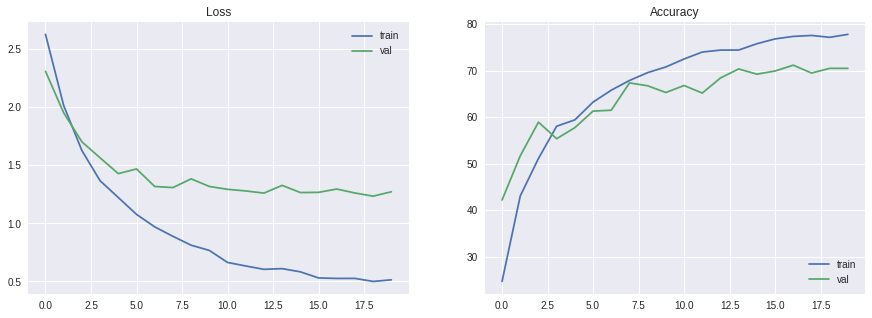

In [52]:
# Plot performance
trainer.plot_performance()

In [53]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 1.24
Test Accuracy: 70.8%


# TODO

* image classification example
* segmentation
* deep CNN architectures
* small 3X3 filters
* details on padding and stride (control receptive field, make every pixel the center of the filter, etc.)
* network-in-network (1x1 conv)
* residual connections / residual block
* interpretability (which n-grams fire)